In [2]:
import pandas as pd
import glob
import csv
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from scipy import stats
import math

In [164]:
###Converting long_read counts to Transcript and gene TPM, saving as csv
long_read = pd.read_csv('/sc/arion/projects/als-omics/microglia_isoseq/isoseq-pipeline/all_samples/cupcake_filtered/all_samples.demux_fl_count_filtered.csv')
long_read = long_read.set_index('id')
#Transcript TPM: divide total read count for each sample and multiply by one million
columns = long_read.columns.tolist()
long_samples = columns
total_count = long_read.sum()
long_read_transcript_tpm = long_read
long_read = long_read.reset_index()
long_read_genes = long_read['id']


def common_elements(list1, list2):
    return list(set(list1) & set(list2))
common_genes = common_elements(short_read_genes, long_read_genes)
long_read_adjusted = long_read[long_read["id"].isin(common_genes)]
long_read_transcript_tpm = long_read_adjusted
long_read_transcript_tpm = long_read_transcript_tpm.set_index('id')
del long_read_transcript_tpm['16-078_1_MFG']
del long_read_transcript_tpm['17-005_2_MFG']
del long_read_transcript_tpm['MG-18_1_MFG']
columns = long_read_transcript_tpm.columns.tolist()
columns = columns[1:]
total_count = long_read_transcript_tpm.sum()



def transcript_tpm(x):
    count_tpm = (x / total) * 1000000
    return count_tpm

for sample in columns:
    total = total_count[sample]
    long_read_transcript_tpm[sample] = long_read_transcript_tpm[sample].apply(transcript_tpm)

#Gene TPM: Sum transcript TPMs across ids
#creating dataframe with gene counts across samples
samples = ['16-078_2_MFG','17-005_1_MFG','18-018_1_MFG','16-110-56_1_SVZ','17-094-37_1_MFG','18-018_1_SVZ','17-009_1_SVZ']

def gene_tpm(data, sample_labels):
    PB_dict = {}
    transcript_list = []
    data = data.reset_index()
    for transcript in data['id']:
        gene_number = math.floor(float(transcript.split('PB.')[1]))
        PB_dict.setdefault(gene_number, []).append(transcript)


    gene_df_temp = []
    gene_df = pd.DataFrame(columns = sample_labels)
    for gene, transcript_list in PB_dict.items():
        gene_df_temp = data[data['id'].isin(transcript_list)]
        gene_df_temp = gene_df_temp.set_index('id')
        sample_counts = gene_df_temp.sum(axis=0)
        gene_df_temp = sample_counts.to_frame().T
        gene_df_temp['gene_id'] = int(gene)
        gene_df = gene_df.append(gene_df_temp)
    gene_df = gene_df.set_index('gene_id')
    return gene_df
long_read_gene_tpm = gene_tpm(long_read_transcript_tpm, samples)
long_read_gene_tpm.to_csv('/sc/arion/projects/als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/long_read_corr.csv')

In [173]:
#processing tx_counts into the correct format and saving csv for correlation analysis
#load data
short_read_tpm = pd.read_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/results_subsample_n_2/SQANTI_short_read_tx_counts.csv')
short_read_tpm.rename(columns = {'Unnamed: 0':'id'}, inplace = True)
short_samples = short_read_tpm.columns.tolist()[1:]
#Reading in metadata and creating columns in short_read_tpm that correspond to long_read column names
metadata = pd.read_excel('/sc/arion/projects/als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/microglia_isoseq_sample_metadata.xlsx')
short_read_id_paired = ['16-078-GFM', '17-005-GFM', '18-018-GFM', '16-078-GFM', '16-110-SVZ', '17-094-GFM', '18-018-SVZ', '17-009-SVZ']
long_read_id = metadata['sample'].tolist()
long_read_id.remove('MG-18_1_MFG')
long_read_id.remove('17-005_2_MFG')

for sample_name in short_read_id_paired:
    index = short_read_id_paired.index(sample_name)
    short_read_tpm[long_read_id[index]] = short_read_tpm[sample_name]

short_read_tpm = short_read_tpm.set_index('id')
columns = short_read_tpm.columns.tolist()
total_counts = short_read_tpm.sum()

def transcript_tpm(x):
    count_tpm = (x / total) * 1000000
    return count_tpm

for sample in columns:
    total = total_counts[sample]
    short_read_tpm[sample] = short_read_tpm[sample].apply(transcript_tpm)

#Creating sub dataframes for correlation
#short_read, removing double sample 
short_read_tpm = short_read_tpm.reset_index()
short_matched_long_df = short_read_tpm.loc[:, long_read_id]
short_matched_long_df['id'] = short_read_tpm['id']
del short_matched_long_df['16-078_1_MFG']
short_matched_long_df = short_matched_long_df.set_index('id')
samples = ['16-078_2_MFG','17-005_1_MFG','18-018_1_MFG','16-110-56_1_SVZ','17-094-37_1_MFG','18-018_1_SVZ','17-009_1_SVZ']

def gene_tpm(data, sample_labels):
    PB_dict = {}
    transcript_list = []
    data = data.reset_index()
    for transcript in data['id']:
        gene_number = math.floor(float(transcript.split('PB.')[1]))
        PB_dict.setdefault(gene_number, []).append(transcript)


    gene_df_temp = []
    gene_df = pd.DataFrame(columns = sample_labels)
    for gene, transcript_list in PB_dict.items():
        gene_df_temp = data[data['id'].isin(transcript_list)]
        gene_df_temp = gene_df_temp.set_index('id')
        sample_counts = gene_df_temp.sum(axis=0)
        gene_df_temp = sample_counts.to_frame().T
        gene_df_temp['gene_id'] = int(gene)
        gene_df = gene_df.append(gene_df_temp)
    gene_df = gene_df.set_index('gene_id')
    return gene_df


short_matched_long_df = gene_tpm(short_matched_long_df, samples)

short_matched_long_df.to_csv('/sc/arion/projects/als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/short_read_corr.csv')

In [62]:
#Convert IDs
ID_dict = {}
gene_conversion = pd.read_csv('/sc/arion/projects/als-omics/microglia_isoseq/collin/data/SQANTI3_filtered/all_samples.cupcake.collapsed.filtered_classification.filtered_lite_classification.txt', sep='\t')
gene_isoform = gene_conversion['isoform'].tolist()
associated_gene = gene_conversion['associated_gene'].tolist()
for PB_id in gene_isoform:
    index = gene_isoform.index(PB_id)
    ID_dict[float(PB_id.split('.')[1])] = associated_gene[index].split('.')[0]
short_read_df = pd.read_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/short_read_corr.csv')
mylist = []
for gene in short_read_df['gene_id']:
    mylist.append(ID_dict[gene])
short_read_df['ensgene'] = mylist
short_read_df.to_csv('/sc/arion/projects/als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/short_read_corr_ensg.csv')


In [69]:
#Loading csv's for short_reads and long_reads and adjusting long_read for genes present in both sets
#Spearman's correlation between short and long read genes
#filtering out samples w/ expression below 0.5TPM
import pandas as pd
short_read_df = pd.read_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/short_read_corr_ensg.csv')
long_read_df = pd.read_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/long_read_corr_ensg.csv')
long_read = long_read_df.set_index('ensgene')
short_read = short_read_df.set_index('ensgene')
long_read = long_read.sort_values('ensgene')
short_read = short_read.sort_values('ensgene')
short_read = short_read.drop(columns=['gene_id', 'Unnamed: 0'])
long_read = long_read.drop(columns=['gene_id', 'Unnamed: 0'])
samples = short_read.columns.tolist()
for sample in samples:
    short_read__expressed = short_read[np.greater_equal(short_read[sample], 0.5)]
    long_read__expressed = long_read[np.greater_equal(long_read[sample], 0.5)]
short_read__expressed.corrwith(long_read__expressed, method='spearman')

16-078_2_MFG       0.702529
16-110-56_1_SVZ    0.525164
17-005_1_MFG       0.636656
17-009_1_SVZ       0.710963
17-094-37_1_MFG    0.702429
18-018_1_MFG       0.581503
18-018_1_SVZ       0.702849
dtype: float64

In [70]:
#highly expressed gene expression only (expression > 1000 TPM)
samples = short_read.columns.tolist()
for sample in samples:
    short_read_highly_expressed = short_read[np.greater_equal(short_read[sample], 1000)]
    long_read_highly_expressed = long_read[np.greater_equal(long_read[sample], 1000)]
short_read_highly_expressed.corrwith(long_read_highly_expressed, method='spearman')


16-078_2_MFG       0.508785
16-110-56_1_SVZ    0.357890
17-005_1_MFG       0.445127
17-009_1_SVZ       0.749648
17-094-37_1_MFG    0.653564
18-018_1_MFG       0.112539
18-018_1_SVZ       0.269136
dtype: float64

In [71]:
#medium expressed gene expression only (expression > 1000 TPM)
samples = short_read.columns.tolist()
for sample in samples:
    short_read_medium_expressed = short_read[np.logical_and(short_read[sample] > 11, short_read[sample] < 1000)]
    long_read_medium_expressed = long_read[np.greater_equal(long_read[sample] > 11, short_read[sample] < 1000)]
short_read_medium_expressed.corrwith(long_read_medium_expressed, method='spearman')

16-078_2_MFG       0.610046
16-110-56_1_SVZ    0.352083
17-005_1_MFG       0.522900
17-009_1_SVZ       0.617643
17-094-37_1_MFG    0.594401
18-018_1_MFG       0.426940
18-018_1_SVZ       0.589629
dtype: float64

In [72]:
#low expressed gene expression only (expression > 1000 TPM)
samples = short_read.columns.tolist()
for sample in samples:
    short_read_low_expressed = short_read[np.logical_and(short_read[sample] > 0.5, short_read[sample] < 11)]
    long_read_low_expressed = long_read[np.greater_equal(long_read[sample] > 0.5, short_read[sample] < 11)]
short_read_low_expressed.corrwith(long_read_low_expressed, method='spearman')

16-078_2_MFG       0.659507
16-110-56_1_SVZ    0.313345
17-005_1_MFG       0.590482
17-009_1_SVZ       0.599631
17-094-37_1_MFG    0.545090
18-018_1_MFG       0.432094
18-018_1_SVZ       0.435666
dtype: float64

In [73]:
short_read_highly_expressed

,16-078_2_MFG,16-110-56_1_SVZ,17-005_1_MFG,17-009_1_SVZ,17-094-37_1_MFG,18-018_1_MFG,18-018_1_SVZ
ensgene,,,,,,,
ENSG00000004534,963.624670,694.702763,1150.717544,1218.282964,982.414693,766.916092,1005.530500
ENSG00000018280,1168.648254,215.127745,567.393825,243.754253,331.711695,963.873364,1965.354640
ENSG00000019582,13425.496505,6511.997519,14285.575983,13089.587531,10593.142343,8210.919961,13074.126534
ENSG00000026297,2035.476691,1384.021374,2447.223473,1464.092895,1200.400147,1720.537413,1663.975411
ENSG00000028137,476.762193,220.162016,739.076849,368.917211,523.833066,455.758036,2034.689660
ENSG00000034510,995.687113,1290.464079,1213.604151,614.744324,365.865561,1602.812232,1110.630578
ENSG00000044574,2637.938990,1594.278861,891.121498,576.502893,737.693545,1561.979085,2271.565243
ENSG00000051108,377.286452,456.634914,270.763712,427.681726,579.522659,334.217995,1193.880283
ENSG00000059804,2236.071567,507.205007,688.175601,139.669308,773.998217,870.014421,2175.437522


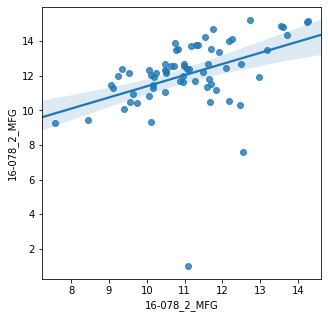

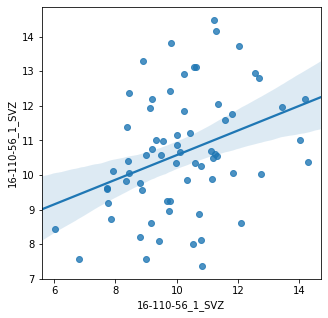

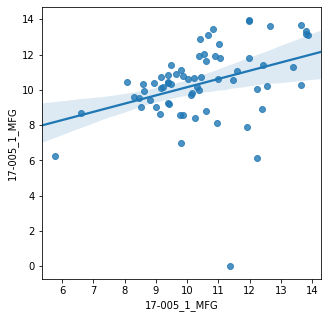

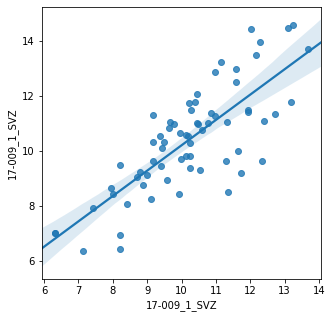

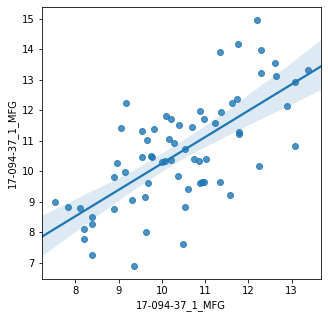

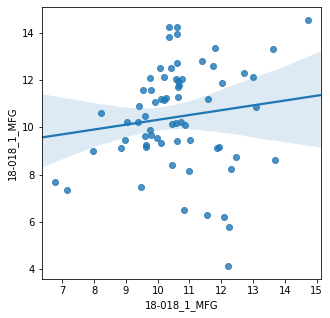

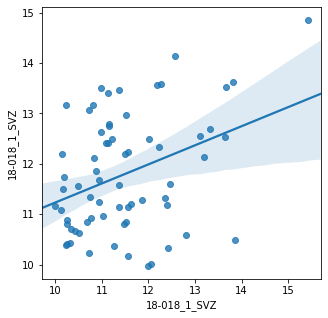

In [76]:
#plotting highly expressed genes
#highly expressed gene expression only (expression > 1000 TPM)
samples = short_read.columns.tolist()
short_read_highly_expressed = []
long_read_highly_expressed = []
for sample in samples:
    short_read_highly_expressed = short_read[np.greater_equal(short_read[sample], 1000)]
    long_read_highly_expressed = long_read[np.greater_equal(long_read[sample], 1000)]

short_read_highly_expressed = short_read_highly_expressed.reset_index()
long_read_highly_expressed = long_read_highly_expressed.reset_index()
short_genes = short_read_highly_expressed['ensgene'].tolist()
long_genes = long_read_highly_expressed['ensgene'].tolist()
def common_elements(list1, list2):
    return list(set(list1) & set(list2))
common_genes = common_elements(short_genes, long_genes)
long_read_highly_expressed_adjusted = long_read_highly_expressed[long_read_highly_expressed["ensgene"].isin(common_genes)]
short_read_highly_expressed_adjusted = short_read_highly_expressed[short_read_highly_expressed["ensgene"].isin(common_genes)]
long_read_highly_expressed_adjusted = long_read_highly_expressed_adjusted.set_index('ensgene')
short_read_highly_expressed_adjusted = short_read_highly_expressed_adjusted.set_index('ensgene')

def log2_plus_one(x):
    transformed_element = np.log2(x+1)
    return transformed_element

long_read_transformed = long_read_highly_expressed_adjusted.apply(log2_plus_one)
short_read_transformed = short_read_highly_expressed_adjusted.apply(log2_plus_one)


for sample in samples:
    fig, ax = plt.subplots(figsize=(5,5), )
    sns.regplot(x = short_read_transformed[sample], y=long_read_transformed[sample])
    plt.show()


In [88]:
short_read_df = pd.read_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/short_read_corr_ensg.csv')
long_read_df = pd.read_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/long_read_corr_ensg.csv')
short_read = short_read_df.drop(columns=['Unnamed: 0'])
long_read = long_read_df.drop(columns=['Unnamed: 0'])
short_read = short_read.set_index('ensgene')
long_read = long_read.set_index('ensgene')
short_read.to_csv('/sc/arion/projects/als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/short_read_corr_ensg.csv')
long_read.to_csv('/sc/arion/projects/als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/long_read_corr_ensg.csv')


In [3]:
pd.read_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/long_read_corr_ensg.csv')

,ensgene,16-078_2_MFG,16-110-56_1_SVZ,17-005_1_MFG,17-009_1_SVZ,17-094-37_1_MFG,18-018_1_MFG,18-018_1_SVZ
0,ENSG00000227232,196.0,314.853399,117.170220,309.180628,83.072595,52.125747,28.927443
1,ENSG00000228794,13.0,3.459927,8.369301,6.547354,7.609703,4.115191,13.187511
2,ENSG00000157873,60.0,59.510752,8.369301,21.097031,29.804672,13.260059,15.739932
3,ENSG00000137760,26.0,8.303826,11.358338,13.094709,6.341419,6.858651,5.955650
4,ENSG00000110660,43.0,22.143536,15.542988,16.732128,15.853549,31.549794,21.270178
5,ENSG00000166266,99.0,20.067579,57.389495,40.011611,31.707097,35.664985,19.143161
6,ENSG00000075239,58.0,11.763753,19.727639,4.364903,10.146271,10.059355,12.336704
7,ENSG00000149311,68.0,40.827144,25.705711,58.198706,45.024078,24.233900,30.203653
8,ENSG00000149308,320.0,129.401287,163.201377,110.577542,157.901345,82.303812,99.119032
9,ENSG00000166323,0.0,0.000000,0.000000,0.000000,0.634142,1.371730,0.000000


In [100]:
pd.read_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/DESEQ_metadata.csv')

,id,region
0,16-078_2_MFG,MFG
1,17-005_1_MFG,MFG
2,18-018_1_MFG,MFG
3,16-110-56_1_SVZ,SVZ
4,17-094-37_1_MFG,MFG
5,18-018_1_SVZ,SVZ
6,17-009_1_SVZ,SVZ


In [1]:
pd.read_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/short_read_corr_ensg.csv')

NameError: name 'pd' is not defined

In [162]:
short_read_df = pd.read_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/short_read_corr_ensg.csv')
gene_list = short_read_df['ensgene'].tolist()
non_duplicates = set(gene_list)

blacklist = []
for gene in gene_list:
    if gene_list.count(gene) > 1:
        if gene not in blacklist:
            blacklist.append(gene)
 
df = short_read_df
short_read = df[~df.ensgene.isin(blacklist)]
short_read
short_read.to_csv('/sc/arion/projects/als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/short_read_corr_ensg.csv', index=False)


In [144]:
long_read_df = pd.read_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/long_read_corr_ensg.csv')
long_read_df.columns.tolist()[1::]

['16-078_2_MFG',
 '16-110-56_1_SVZ',
 '17-005_1_MFG',
 '17-009_1_SVZ',
 '17-094-37_1_MFG',
 '18-018_1_MFG',
 '18-018_1_SVZ']

In [163]:
#create metaData frame w/ row as sample IDs and column w/ region (SVZ, MFG)
short_read_df = pd.read_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/short_read_corr_ensg.csv')
samples = short_read_df.columns.tolist()[1::]
SVZ = ['16-110-56_1_SVZ', '18-018_1_SVZ', '17-009_1_SVZ']
MFG = ['16-078_2_MFG','17-005_1_MFG','18-018_1_MFG','17-094-37_1_MFG' ]
mydf = []
mydf = pd.DataFrame(samples, columns=['id'])
region = []
for sample in samples:
    if sample in SVZ:
        region.append('SVZ')
    else:
        region.append('MFG')
mydf['region'] = region
mydf.to_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/DESEQ_metadata_short.csv', index=False)

In [164]:
#transform to integer
short_read_df = pd.read_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/short_read_corr_ensg.csv')
short_read_df = short_read_df.set_index('ensgene')
def to_int(x):
    integer = int(x)
    return integer
for sample in short_read_df.columns.tolist():
    short_read_df[sample] = short_read_df[sample].apply(to_int)
short_read_df.to_csv('/sc/arion/projects/als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/short_read_DESEQ.csv')


In [158]:
df = pd.read_csv('/sc/arion/projects//als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/DESEQ_results_long_read.csv')
p_adjusted = df[df['pvalue'] < 0.05]
p_adjusted.to_csv('/sc/arion/projects/als-omics/microglia_isoseq/collin/RNA-pipelines/kallisto-pipeline/long_read_DESEQ_padjust.csv')

In [165]:
short_read_df

,16-078_2_MFG,16-110-56_1_SVZ,17-005_1_MFG,17-009_1_SVZ,17-094-37_1_MFG,18-018_1_MFG,18-018_1_SVZ
ensgene,,,,,,,
ENSG00000227232,59,45,46,182,88,25,24
ENSG00000279457,43,14,32,42,47,27,15
ENSG00000237491,7,7,6,9,22,8,2
ENSG00000230092,13,24,18,22,71,25,7
ENSG00000228794,41,17,26,35,67,25,54
ENSG00000188976,61,20,55,44,41,52,51
ENSG00000187608,50,66,53,36,62,43,23
ENSG00000188157,0,1,0,0,2,0,0
ENSG00000131591,11,2,12,13,19,6,6
